## Notebook runs BERT(english) and BETO(spanish) for TASK-1 and TASK-2

In [ ]:
pip install contractions emoji simpletransformers

     |████████████████████████████████| 170 kB 5.4 MB/s 
     |████████████████████████████████| 247 kB 36.3 MB/s 
     |████████████████████████████████| 284 kB 34.4 MB/s 
     |████████████████████████████████| 321 kB 38.6 MB/s 
     |████████████████████████████████| 290 kB 45.1 MB/s 
     |████████████████████████████████| 1.7 MB 40.4 MB/s 
     |████████████████████████████████| 3.3 MB 36.4 MB/s 
     |████████████████████████████████| 1.2 MB 28.6 MB/s 
     |████████████████████████████████| 9.1 MB 20.6 MB/s 
     |████████████████████████████████| 3.1 MB 34.9 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 59 kB 6.4 MB/s 
     |████████████████████████████████| 895 kB 41.3 MB/s 
     |████████████████████████████████| 596 kB 46.6 MB/s 
     |████████████████████████████████| 180 kB 44.6 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
     |████████████████████████████████| 140 kB 42.5 MB/s 
     |███████████████

In [ ]:
import pandas as pd
import numpy as np
import string
import regex as re
import contractions
import emoji
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, ClassificationModel
import seaborn as sns
import matplotlib.pyplot as plt   

In [ ]:
def expand_hashtags ( sentences):
        hashtag_pattern = re.compile (r'#([\p{L}0-9\_]+)')
        return sentences.apply (lambda x: re.sub (hashtag_pattern, lambda match: camel_case_split (match.group (1)), x))

def camel_case_split ( identifier):
        # link https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python/29920015
        
        matches = re.finditer ('.+?(?:(?<=\p{Ll})(?=\p{Lu})|(?<=\p{Lu})(?=\p{Lu}\p{Ll})|[0-9]+|$)', identifier)
        return ' '.join ([m.group (0) for m in matches])

In [ ]:
def expand_contractions(text):
    return contractions.fix(text)

In [ ]:
def remove_links(s):
    removeLinksPattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',re.DOTALL)
    tmp = re.sub(removeLinksPattern, ' ', s)#, flags = re.DOTALL)
    return tmp 

In [ ]:
def remove_mentions(text):
    begining_mentions_pattern = re.compile (r"^(@[A-Za-z0-9\_]+\s?)+")
    middle_mentions_pattern = re.compile (r'(?<!\b)@([A-Za-z0-9\_]+)\b(?<!user)')
    txt = text.apply (lambda x: re.sub (begining_mentions_pattern, '', x))
    return txt

In [ ]:
def remove_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.sub(percents_pattern, ' ', x))#   re.findall(percents_pattern, text)

def check_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.findall(percents_pattern,  x))#   re.findall(percents_pattern, text)

In [ ]:
def remove_digits (text, replace = '[NUMERO]'):
        digits_pattern = re.compile (r"\b(\d+[\.,]?\d*|\d{2}[AP]M)\b")
        return text.apply (lambda x: re.sub (digits_pattern, replace, x))

In [ ]:
# link https://stackoverflow.com/questions/24893977/whats-the-best-way-to-regex-replace-a-string-in-python-but-keep-its-case
def replace_keep_case (word, replacement, text):
    def func (match):
        g = match.group ()
        if g.islower (): return replacement.lower ()
        if g.istitle (): return replacement.title ()
        if g.isupper (): return replacement.upper ()
        return replacement
    return re.sub (word, func, text)

def remove_elongations (text):
        laughs_pattern = re.compile (r'(?i)\b(mua)?j[ja]+a?\b')
        # Remove laughs
        txt = text.apply (lambda x: re.sub (laughs_pattern, 'jajaja', x))

        
        # Remove exclamatory and interrogative
        for character in ['!', '¡', '?', '¿']:
            pattern = re.compile ('\\' + character + '{2,}')
            txt = txt.apply (lambda x: re.sub (pattern, character, x))
        
        # Add (.)\1{2,}|[aá]{2,}|[eé]{2,}|[ií]{2,}|[oó]{2,}|[uú]{2,})
        elongation_pattern = re.compile (r'(.)\1{2,}')
        # Remove letters longer than 2
        txt = txt.apply (lambda x: re.sub (elongation_pattern, r'\1', x))
        
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[aá]{2,}'), "á", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[eé]{2,}'), "é", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[ií]{2,}'), "í", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[oó]{2,}'), "ó", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[uú]{2,}'), "ú", x))
        return txt

In [ ]:
def remove_emojis (text):
        return text.apply (lambda x: emoji.get_emoji_regexp ().sub (u'', x))

In [ ]:
def remove_quotations (text):
        quotations_pattern = r'["“”\'«»‘’]'
        return text.replace (to_replace = quotations_pattern, value = '', regex = True)

In [ ]:
def remove_punctuation (text):
    punctuation_pattern = re.compile ("[" + re.escape(string.punctuation) + "]")
    #print(punctuation_pattern)
    punc = text.apply (lambda x: re.findall(punctuation_pattern,  x))
    #print(punc)
    return text.apply (lambda x: re.sub (punctuation_pattern, '', x))

In [ ]:
def preprocessData(text):
  txt = expand_hashtags(text)
  txt = txt.apply(lambda x: expand_contractions(x))
  txt = txt.apply(lambda x: remove_links(x))
  txt = remove_mentions(txt)
  txt = remove_percentages(txt)
  txt = remove_digits(txt)
  txt = remove_elongations(txt)
  txt = remove_emojis(txt)
  txt = txt.str.lower()
  txt = remove_quotations(txt)
  txt = remove_punctuation(txt)
  txt = txt.apply(lambda x: x.strip())
  return txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_test_labeled.tsv", sep="\t")

In [ ]:
# train_data = train_data.drop(["test_case", "source", "language", "id"], axis = 1)

### **Preprocessing**

In [ ]:
train_data.text = preprocessData(train_data.text)
test_data.text = preprocessData(test_data.text)

In [ ]:
train_data.head(5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,she calls herself antifeminazi how about shut ...,sexist,ideological-inequality
1,EXIST2021,2,twitter,en,now back to these women the brave and the beau...,non-sexist,non-sexist
2,EXIST2021,3,twitter,en,wow your skirt is very short what is it is len...,sexist,objectification
3,EXIST2021,4,twitter,en,incredible beautifulbut i laughed so much whe...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


In [ ]:
test_data.head(5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,6978,gab,en,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist
1,EXIST2021,6979,twitter,en,he sounds like as ass and very condescending,non-sexist,non-sexist
2,EXIST2021,6980,twitter,en,lol this behavior of not letting men tell you ...,sexist,ideological-inequality
3,EXIST2021,6981,twitter,en,rightsi mean yeah most women especially the wo...,sexist,ideological-inequality
4,EXIST2021,6982,twitter,en,the jack manifold appreciation i am séing is o...,non-sexist,non-sexist


### Creating binary labels for task - 1 for both train and test data

In [ ]:
encoder_task1 = LabelBinarizer()
encoder_task1.fit(train_data['task1'])
transformed = encoder_task1.transform(train_data['task1'])
train_data['label-task-1'] = pd.DataFrame(transformed)

encoder_task1.fit(test_data['task1'])
transformed = encoder_task1.transform(test_data['task1'])
test_data['label-task-1'] = pd.DataFrame(transformed)

# BERT

In [ ]:
train_data_english = train_data[train_data.language != 'es']
test_data_english = test_data[test_data.language != 'es']

In [ ]:
print(train_data_english.shape, test_data_english.shape)

(3436, 8) (2208, 8)


### Class size in train data

In [ ]:
train_data_english.groupby(['task1']).size()

task1
non-sexist    1800
sexist        1636
dtype: int64

### Class size in test data

In [ ]:
test_data_english.groupby(['task1']).size()

task1
non-sexist    1050
sexist        1158
dtype: int64

### dropping useless columns

In [ ]:
train_data_english = train_data_english.drop(["test_case", "source", "language", "id"], axis = 1)
test_data_english = test_data_english.drop(["test_case", "source", "language", "id"], axis = 1)

In [ ]:
train_data_english.head(5)

,text,task1,task2,label-task-1
0,she calls herself antifeminazi how about shut ...,sexist,ideological-inequality,1
1,now back to these women the brave and the beau...,non-sexist,non-sexist,0
2,wow your skirt is very short what is it is len...,sexist,objectification,1
3,incredible beautifulbut i laughed so much whe...,non-sexist,non-sexist,0
4,i find it extremely hard to believe that kelly...,non-sexist,non-sexist,0


In [ ]:
test_data_english.head(5)

,text,task1,task2,label-task-1
0,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist,0
1,he sounds like as ass and very condescending,non-sexist,non-sexist,0
2,lol this behavior of not letting men tell you ...,sexist,ideological-inequality,1
3,rightsi mean yeah most women especially the wo...,sexist,ideological-inequality,1
4,the jack manifold appreciation i am séing is o...,non-sexist,non-sexist,0


In [ ]:
def display_classification_stats(result):
  confusion_matrix = np.zeros((2,2))
  confusion_matrix[0][0] = result['tn']
  confusion_matrix[0][1] = result['fp']
  confusion_matrix[1][0] = result['fn']
  confusion_matrix[1][1] = result['tp']


  precision =  result['tp'] / ( result['tp'] + result['fp'] )
  recall = result['tp'] / ( result['tp'] + result['fn'] )
  F_score =  2 * precision * recall / (precision + recall)
  accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1])/np.sum(confusion_matrix)
  print("ACCURACY  : ", accuracy)
  print("PRECISION : ", precision)
  print("RECALL    : ", recall)
  print("F1        : ", F_score)

  print(confusion_matrix)
  ax= plt.subplot()
  sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['non-sexism', 'sexism']); ax.yaxis.set_ticklabels(['non-sexism', 'sexism']);

In [ ]:
def display_classification_stats_task2(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    target_names = ['ideological\ninequality', 'misogyny\nnon-sexual\nviolence', 'objectification', 'sexual\nviolence', 'stereotyping\ndominance' ]
    target_names2 = ['ideological inequality', 'misogyny non-sexual violence', 'objectification', 'sexual violence', 'stereotyping dominance' ]
    print(classification_report(y_true, y_pred, target_names=target_names2))
    plt.figure(figsize = (15,10))
    ax= plt.subplot()
    sns.heatmap(cf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(target_names,rotation=0, fontsize="17")
    ax.yaxis.set_ticklabels(target_names, rotation=0, fontsize="17")

## Task1

In [ ]:
model_bert_task1_english = ClassificationModel( 'bert', 'bert-base-uncased', args={'train_batch_size':4, 'learning_rate': 3e-5, 'num_train_epochs': 1, 'max_seq_length': 512, 'overwrite_output_dir': True})

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
model_bert_task1_english.train_model(train_data_english[['text','label-task-1']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3436 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/859 [00:00<?, ?it/s]

(859, 0.563464629913792)

In [ ]:
result, model_outputs, wrong_predictions = model_bert_task1_english.eval_model(test_data_english[['text','label-task-1']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2208 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/276 [00:00<?, ?it/s]

In [ ]:
result

{'auprc': 0.8132706193450857,
 'auroc': 0.8280463031499302,
 'eval_loss': 0.5544116116952205,
 'fn': 167,
 'fp': 344,
 'mcc': 0.5394761690001453,
 'tn': 706,
 'tp': 991}

ACCURACY  :  0.7685688405797102
PRECISION :  0.7423220973782771
RECALL    :  0.8557858376511226
F1        :  0.7950260730044123
[[706. 344.]
 [167. 991.]]


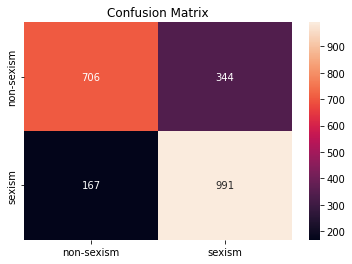

In [ ]:
display_classification_stats(result)

In [ ]:
predictions, raw_outputs = model_bert_task1_english.predict(list(test_data_english.text.values))

  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

print('Accuracy on Test Data:', accuracy_score(test_data_english['label-task-1'],predictions))
print('F1-Score on Test Data:', f1_score(test_data_english['label-task-1'],predictions))
print('Confusion Matrix on Test Data:\n', confusion_matrix(test_data_english['label-task-1'],predictions))
print('Classification on Test Data:\n', classification_report(test_data_english['label-task-1'],predictions))

Accuracy on Test Data: 0.7685688405797102
F1-Score on Test Data: 0.7950260730044123
Confusion Matrix on Test Data:
 [[706 344]
 [167 991]]
Classification on Test Data:
               precision    recall  f1-score   support

           0       0.81      0.67      0.73      1050
           1       0.74      0.86      0.80      1158

    accuracy                           0.77      2208
   macro avg       0.78      0.76      0.76      2208
weighted avg       0.77      0.77      0.77      2208



## Task 2

In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_test_labeled.tsv", sep="\t")

train_data = train_data[train_data.task2 != 'non-sexist']
test_data = test_data[test_data.task2 != 'non-sexist']

d = {
    'ideological-inequality'       : 0,         
    'misogyny-non-sexual-violence' : 1,    
    'objectification'              : 2,   
    'sexual-violence'              : 3,   
    'stereotyping-dominance'       : 4   
}

train_data = train_data.replace({"task2": d})
test_data = test_data.replace({"task2": d})

train_data_english = train_data[train_data.language != 'es']
test_data_english = test_data[test_data.language != 'es']

train_data_english = train_data_english.drop(["test_case", "source", "language", "id", "task1"], axis = 1)
test_data_english = test_data_english.drop(["test_case", "source", "language", "id", "task1"], axis = 1)

train_data_english.text = preprocessData(train_data_english.text)
test_data_english.text = preprocessData(test_data_english.text)

In [ ]:
model_bert_task2_english = ClassificationModel( 'bert', 'bert-base-uncased',num_labels=5, args={'train_batch_size':4, 'learning_rate': 3e-5, 'num_train_epochs': 1, 'max_seq_length': 512, 'overwrite_output_dir': True})

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model_bert_task2_english.train_model(train_data_english)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1636 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/409 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(409, 1.256375431723)

In [ ]:
result_en2, model_outputs_en2, wrong_predictions_en2 = model_bert_task2_english.eval_model(test_data_english)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1158 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
predictions_en2, raw_outputs = model_bert_task2_english.predict(list(test_data_english.text.values))

  0%|          | 0/1158 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

                              precision    recall  f1-score   support

      ideological inequality       0.74      0.68      0.71       333
misogyny non-sexual violence       0.49      0.40      0.44       215
             objectification       0.52      0.50      0.51       150
             sexual violence       0.59      0.73      0.65       198
      stereotyping dominance       0.54      0.58      0.56       262

                    accuracy                           0.59      1158
                   macro avg       0.57      0.58      0.57      1158
                weighted avg       0.59      0.59      0.59      1158



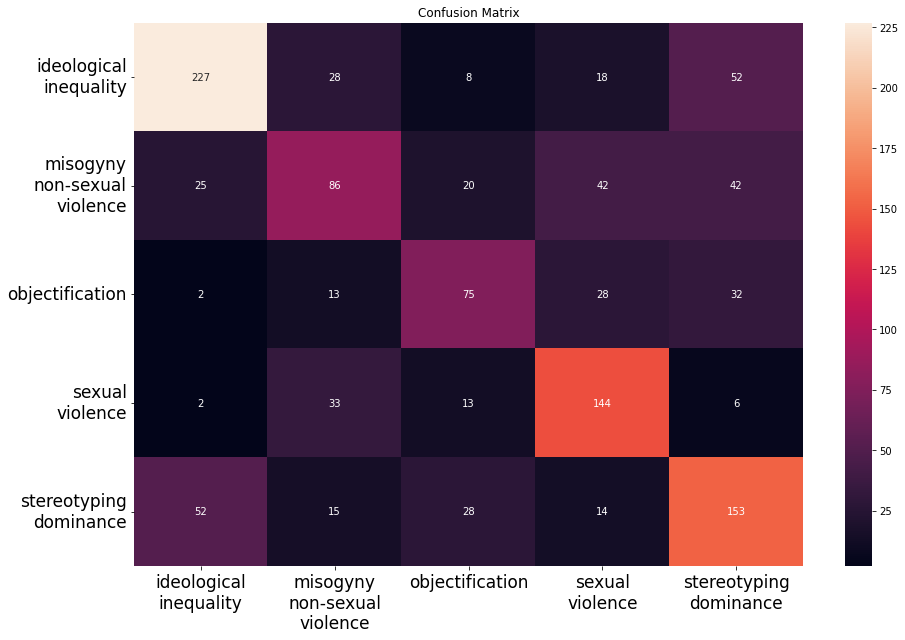

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
y_true = test_data_english.task2.values
y_pred = predictions_en2
display_classification_stats_task2(y_true, y_pred)

In [ ]:
print('Accuracy on Test Data:', accuracy_score(y_true,y_pred))

Accuracy on Test Data: 0.5915371329879102


# BETO

In [ ]:
# Fist install the library and download the models from github

!pip install transformers
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

--2021-11-22 16:33:58--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409871727 (391M) [application/x-gzip]
Saving to: ‘pytorch_weights.tar.gz’

pytorch_weights.tar 100%[===================>] 390.88M  5.38MB/s    in 53s     

2021-11-22 16:34:52 (7.36 MB/s) - ‘pytorch_weights.tar.gz’ saved [409871727/409871727]

--2021-11-22 16:34:52--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242120 (236K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>] 236.45K   481KB/s    in 0.5s

In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_test_labeled.tsv", sep="\t")

In [ ]:
train_data.text = preprocessData(train_data.text)
test_data.text = preprocessData(test_data.text)

In [ ]:
encoder_task1 = LabelBinarizer()
encoder_task1.fit(train_data['task1'])
transformed = encoder_task1.transform(train_data['task1'])
train_data['label-task-1'] = pd.DataFrame(transformed)

encoder_task1.fit(test_data['task1'])
transformed = encoder_task1.transform(test_data['task1'])
test_data['label-task-1'] = pd.DataFrame(transformed)

In [ ]:
train_data_spanish = train_data[train_data.language != 'en']
test_data_spanish = test_data[test_data.language != 'en']

In [ ]:
test_data_spanish

,test_case,id,source,language,text,task1,task2,label-task-1
2208,EXIST2021,9186,gab,es,y te golpeo más fuerte perra,sexist,misogyny-non-sexual-violence,1
2209,EXIST2021,9187,twitter,es,castigado tres meses sin salir y la chica no v...,non-sexist,non-sexist,0
2210,EXIST2021,9188,twitter,es,jajaja el me he topado con tantos de la onda n...,sexist,stereotyping-dominance,1
2211,EXIST2021,9189,twitter,es,resulta que hoy es el día de la juventud y no ...,non-sexist,non-sexist,0
2212,EXIST2021,9190,twitter,es,los que dicen que crén en la igualdad pero que...,sexist,ideological-inequality,1
...,...,...,...,...,...,...,...,...
4363,EXIST2021,11341,twitter,es,se llama nota de corte y es lo que determina s...,non-sexist,non-sexist,0
4364,EXIST2021,11342,twitter,es,osea todo atack of titan parte de una niña ena...,non-sexist,non-sexist,0
4365,EXIST2021,11343,twitter,es,cuéntame máses por androcentrismo tal vez,sexist,ideological-inequality,1
4366,EXIST2021,11344,gab,es,que duro es ser tan atractiva como jaba de hutt,sexist,objectification,1


In [ ]:
print(train_data_spanish.shape, test_data_spanish.shape)

(3541, 8) (2160, 8)


In [ ]:
train_data_spanish.groupby(['task1']).size()

task1
non-sexist    1800
sexist        1741
dtype: int64

In [ ]:
test_data_spanish.groupby(['task1']).size()

task1
non-sexist    1037
sexist        1123
dtype: int64

In [ ]:
train_data_spanish

,test_case,id,source,language,text,task1,task2,label-task-1
3436,EXIST2021,3437,twitter,es,nadie te va a tratar tan bien como un hombre q...,sexist,sexual-violence,1
3437,EXIST2021,3438,twitter,es,que rica putita obediente afortunado tu marido...,sexist,stereotyping-dominance,1
3438,EXIST2021,3439,twitter,es,yo lo hice a los numero años por la carretera ...,non-sexist,non-sexist,0
3439,EXIST2021,3440,twitter,es,las cosas q sueño son indicios de que yo enrea...,non-sexist,non-sexist,0
3440,EXIST2021,3441,twitter,es,pero a la niña le gustó desde que lo vió así q...,non-sexist,non-sexist,0
...,...,...,...,...,...,...,...,...
6972,EXIST2021,6973,twitter,es,estamos igual sin pareja pero puedes besar a t...,non-sexist,non-sexist,0
6973,EXIST2021,6974,twitter,es,numero hijo de re mil putas,non-sexist,non-sexist,0
6974,EXIST2021,6975,twitter,es,seguramente esta chica no cobra el dinero que ...,non-sexist,non-sexist,0
6975,EXIST2021,6976,twitter,es,mi madre dice q va fea y i agré,sexist,objectification,1


In [ ]:
train_data_spanish = train_data_spanish.drop(["test_case", "source", "language", "id"], axis = 1)
test_data_spanish = test_data_spanish.drop(["test_case", "source", "language", "id"], axis = 1)

In [ ]:
train_data_spanish.head(5)

,text,task1,task2,label-task-1
3436,nadie te va a tratar tan bien como un hombre q...,sexist,sexual-violence,1
3437,que rica putita obediente afortunado tu marido...,sexist,stereotyping-dominance,1
3438,yo lo hice a los numero años por la carretera ...,non-sexist,non-sexist,0
3439,las cosas q sueño son indicios de que yo enrea...,non-sexist,non-sexist,0
3440,pero a la niña le gustó desde que lo vió así q...,non-sexist,non-sexist,0


In [ ]:
train_data_spanish.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3541 entries, 3436 to 6976
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          3541 non-null   object
 1   task1         3541 non-null   object
 2   task2         3541 non-null   object
 3   label-task-1  3541 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 138.3+ KB


In [ ]:
test_data_spanish.head(5)

,text,task1,task2,label-task-1
2208,y te golpeo más fuerte perra,sexist,misogyny-non-sexual-violence,1
2209,castigado tres meses sin salir y la chica no v...,non-sexist,non-sexist,0
2210,jajaja el me he topado con tantos de la onda n...,sexist,stereotyping-dominance,1
2211,resulta que hoy es el día de la juventud y no ...,non-sexist,non-sexist,0
2212,los que dicen que crén en la igualdad pero que...,sexist,ideological-inequality,1


## Task 1

In [ ]:
model_beto_task1_spanish = ClassificationModel( 'bert', 'dccuchile/bert-base-spanish-wwm-uncased', args={'train_batch_size':4, 'learning_rate': 3e-5, 'num_train_epochs': 1, 'max_seq_length': 256, 'overwrite_output_dir': True})


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [ ]:
train_data_spanish.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3541 entries, 3436 to 6976
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          3541 non-null   object
 1   task1         3541 non-null   object
 2   task2         3541 non-null   object
 3   label-task-1  3541 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 138.3+ KB


In [ ]:
model_beto_task1_spanish.train_model(train_data_spanish[['text','label-task-1']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3541 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/886 [00:00<?, ?it/s]

(886, 0.6064804714366491)

In [ ]:
result_es, model_outputs_es, wrong_predictions_es = model_beto_task1_spanish.eval_model(test_data_spanish[['text','label-task-1']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2160 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

In [ ]:
result_es

{'auprc': 0.8505009030199382,
 'auroc': 0.8444254480911527,
 'eval_loss': 0.5244681181731048,
 'fn': 262,
 'fp': 235,
 'mcc': 0.5397121003897744,
 'tn': 802,
 'tp': 861}

ACCURACY  :  0.7699074074074074
PRECISION :  0.7855839416058394
RECALL    :  0.7666963490650045
F1        :  0.77602523659306
[[802. 235.]
 [262. 861.]]


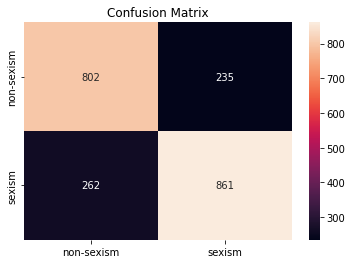

In [ ]:
display_classification_stats(result_es)

In [ ]:
predictions_es, raw_outputs = model_beto_task1_spanish.predict(list(test_data_spanish.text.values))

  0%|          | 0/2160 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

print('Accuracy on Test Data:', accuracy_score(test_data_spanish['label-task-1'],predictions_es))
print('F1-Score on Test Data:', f1_score(test_data_spanish['label-task-1'],predictions_es))
print('Confusion Matrix on Test Data:\n', confusion_matrix(test_data_spanish['label-task-1'],predictions_es))
print('Classification on Test Data:\n', classification_report(test_data_spanish['label-task-1'],predictions_es))

Accuracy on Test Data: 0.7699074074074074
F1-Score on Test Data: 0.77602523659306
Confusion Matrix on Test Data:
 [[802 235]
 [262 861]]
Classification on Test Data:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76      1037
           1       0.79      0.77      0.78      1123

    accuracy                           0.77      2160
   macro avg       0.77      0.77      0.77      2160
weighted avg       0.77      0.77      0.77      2160



## Task 2

In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_test_labeled.tsv", sep="\t")

train_data = train_data[train_data.task2 != 'non-sexist']
test_data = test_data[test_data.task2 != 'non-sexist']

d = {
    'ideological-inequality'       : 0,         
    'misogyny-non-sexual-violence' : 1,    
    'objectification'              : 2,   
    'sexual-violence'              : 3,   
    'stereotyping-dominance'       : 4   
}

train_data = train_data.replace({"task2": d})
test_data = test_data.replace({"task2": d})

train_data_spanish = train_data[train_data.language != 'en']
test_data_spanish = test_data[test_data.language != 'en']

train_data_spanish = train_data_spanish.drop(["test_case", "source", "language", "id", "task1"], axis = 1)
test_data_spanish = test_data_spanish.drop(["test_case", "source", "language", "id", "task1"], axis = 1)

train_data_spanish.text = preprocessData(train_data_spanish.text)
test_data_spanish.text = preprocessData(test_data_spanish.text)

In [ ]:
train_data_spanish.head()

,text,task2
3436,nadie te va a tratar tan bien como un hombre q...,3
3437,que rica putita obediente afortunado tu marido...,4
3443,sigues lloriqueando no me des la brasa nenaza,1
3446,perdonar lo no sólo es posible es absolutament...,0
3447,el odio que te tengo nunca se me va a quitar p...,1


In [ ]:
test_data_spanish.head()

,text,task2
2208,y te golpeo más fuerte perra,1
2210,jajaja el me he topado con tantos de la onda n...,4
2212,los que dicen que crén en la igualdad pero que...,0
2215,por dios como no podes querer a mis gatas conc...,2
2218,mujer al volante causa terror video,4


In [ ]:
train_data_spanish.groupby(['task2']).size()

task2
0    480
1    401
2    244
3    173
4    443
dtype: int64

In [ ]:
test_data_spanish.groupby(['task2']).size()

task2
0    288
1    257
2    174
3    202
4    202
dtype: int64

In [ ]:
model_beto_task2_spanish = ClassificationModel( 'bert', 'dccuchile/bert-base-spanish-wwm-uncased',num_labels=5, args={'train_batch_size':4, 'learning_rate': 3e-5, 'num_train_epochs': 1, 'max_seq_length': 256, 'overwrite_output_dir': True})


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [ ]:
model_beto_task2_spanish.train_model(train_data_spanish)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1741 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/436 [00:00<?, ?it/s]

(436, 1.1003309739839047)

In [ ]:
result_es2, model_outputs_es2, wrong_predictions_es2 = model_beto_task2_spanish.eval_model(test_data_spanish)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1123 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/141 [00:00<?, ?it/s]

In [ ]:
predictions, raw_outputs = model_beto_task2_spanish.predict(list(test_data_spanish.text.values))

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

                              precision    recall  f1-score   support

      ideological inequality       0.72      0.82      0.76       288
misogyny non-sexual violence       0.56      0.61      0.58       257
             objectification       0.71      0.50      0.59       174
             sexual violence       0.75      0.63      0.68       202
      stereotyping dominance       0.57      0.62      0.59       202

                    accuracy                           0.65      1123
                   macro avg       0.66      0.63      0.64      1123
                weighted avg       0.66      0.65      0.65      1123



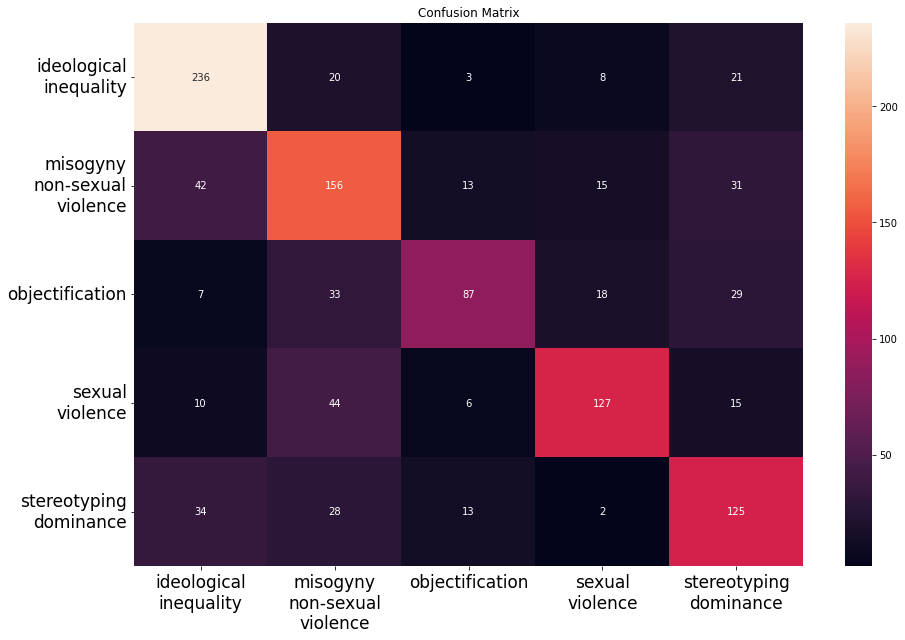

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
y_true = test_data_spanish.task2.values
y_pred = predictions
display_classification_stats_task2(y_true, y_pred)